In [34]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib as plt
import seaborn as sns


In [6]:
gas_dat = pd.read_pickle('../data/processed/gas_demand.pkl')

In [7]:
gas_dat.head()

,s1_deg_c,s2_deg_c,s1_wind,s2_wind,gas_demand
2013-10-01,10.32,11.58,8.47,6.32,71.87
2013-10-02,10.35,11.54,9.23,7.31,76.93
2013-10-03,11.67,13.28,10.13,6.67,72.70
2013-10-04,13.19,15.27,10.33,5.32,61.30
2013-10-05,12.49,14.17,5.90,3.60,52.51


In [10]:
gas_base = gas_dat[:'2017-12-31']

In [11]:
gas_base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1553 entries, 2013-10-01 to 2017-12-31
Freq: D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   s1_deg_c    1553 non-null   float64
 1   s2_deg_c    1553 non-null   float64
 2   s1_wind     1553 non-null   float64
 3   s2_wind     1553 non-null   float64
 4   gas_demand  1553 non-null   float64
dtypes: float64(5)
memory usage: 112.8 KB


Using the univariate fbProphet as the base prediction case - this will pick up the weekly and annual seasonality and the trend.

In [19]:
m = Prophet()
gas_predict_src = gas_base['gas_demand'].reset_index()
gas_predict_src.columns = ['ds','y']
m.fit(gas_predict_src)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=365)
future.tail()


,ds
1913,2018-12-27
1914,2018-12-28
1915,2018-12-29
1916,2018-12-30
1917,2018-12-31


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1913,2018-12-27,141.874091,122.401587,161.668782
1914,2018-12-28,140.874384,121.262366,160.694571
1915,2018-12-29,133.553919,112.693431,152.480313
1916,2018-12-30,133.711567,113.298456,153.012113
1917,2018-12-31,145.893183,125.217449,166.165417


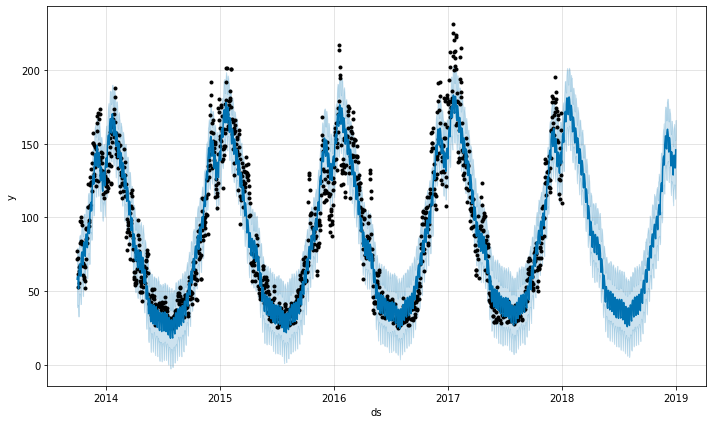

In [22]:
fig1 = m.plot(forecast)

This shows clearly the drop over the weekend in gas demand - i.e. the weekly seasonality.

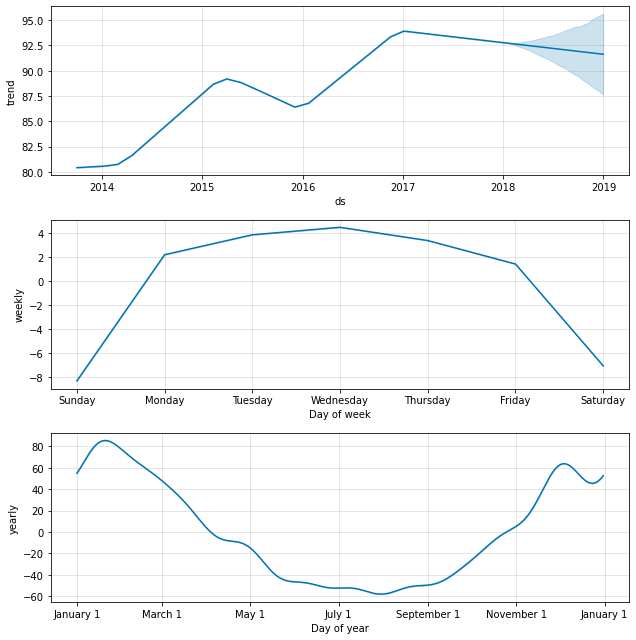

In [23]:
fig2 = m.plot_components(forecast)

2018-01-01    125.15
2018-01-02    141.75
2018-01-03    146.65
2018-01-04    139.01
2018-01-05    141.22
               ...  
2018-12-27    162.92
2018-12-28    161.24
2018-12-29    138.05
2018-12-30    123.78
2018-12-31    120.33
Freq: D, Name: gas_demand, Length: 365, dtype: float64

In [45]:
def mae_and_plot(forecast_df,actual_2018):
    p_predicted = forecast['yhat'].tail(365).values
    print(mean_absolute_error(p_predicted,actual_2018))
    pd.DataFrame({'Predicted':p_predicted,'Actual':actual_2018}).plot()

In [ ]:
actual_2018 = gas_dat['gas_demand']['2018-01-01':'2018-12-31'].values

16.20326189643255


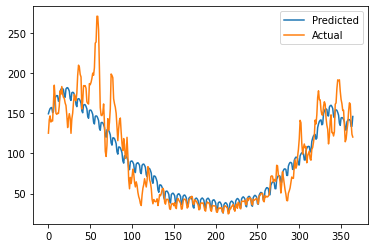

In [47]:
mae_and_plot(forecast,actual_2018)

Multiplicative Seasonality

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


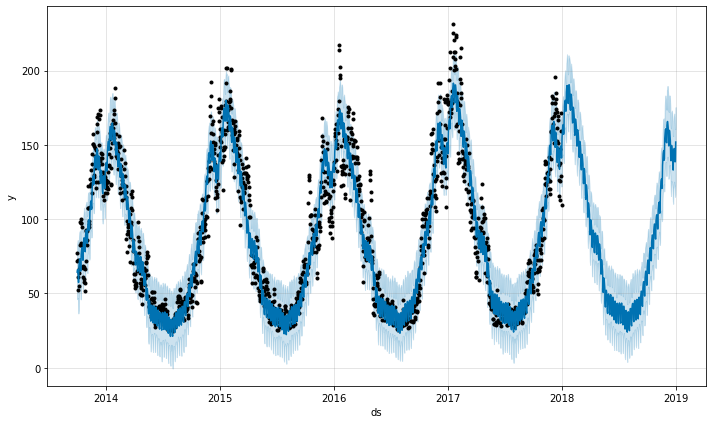

In [48]:
# Python
m = Prophet(seasonality_mode='multiplicative')
m.fit(gas_predict_src)
forecast = m.predict(future)
fig = m.plot(forecast)


16.04948352947562


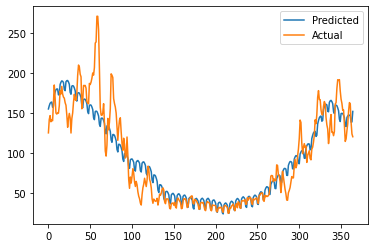

In [49]:
mae_and_plot(forecast,actual_2018)

Adding a predicted average of the temperature as a regressor


In [51]:
temp_predict = gas_base.assign(avg_temp = (gas_base['s1_deg_c'] +gas_base['s2_deg_c'] )/2)['avg_temp'].reset_index()
temp_predict.columns = ['ds','y']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


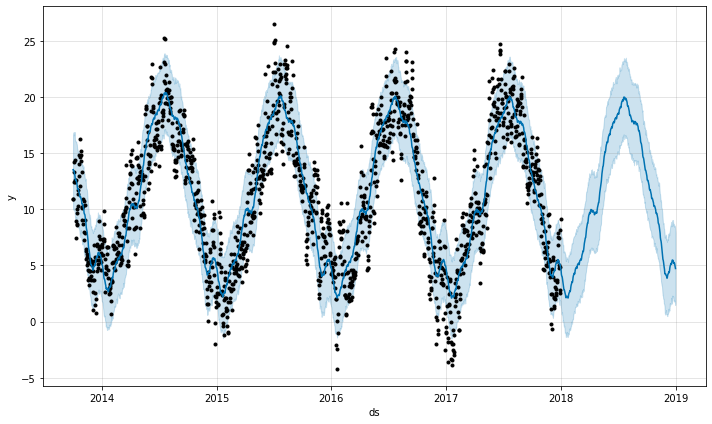

In [53]:

m_temp = Prophet()
m_temp.fit(temp_predict)
forecast_temp = m_temp.predict(future)
fig = m_temp.plot(forecast_temp)

In [56]:
gas_predict_regr = gas_predict_src.assign(avg_temp = temp_predict['y'])

In [70]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('avg_temp')
m.fit(gas_predict_regr)
future_regr = future.assign(avg_temp=forecast_temp['yhat'].values)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


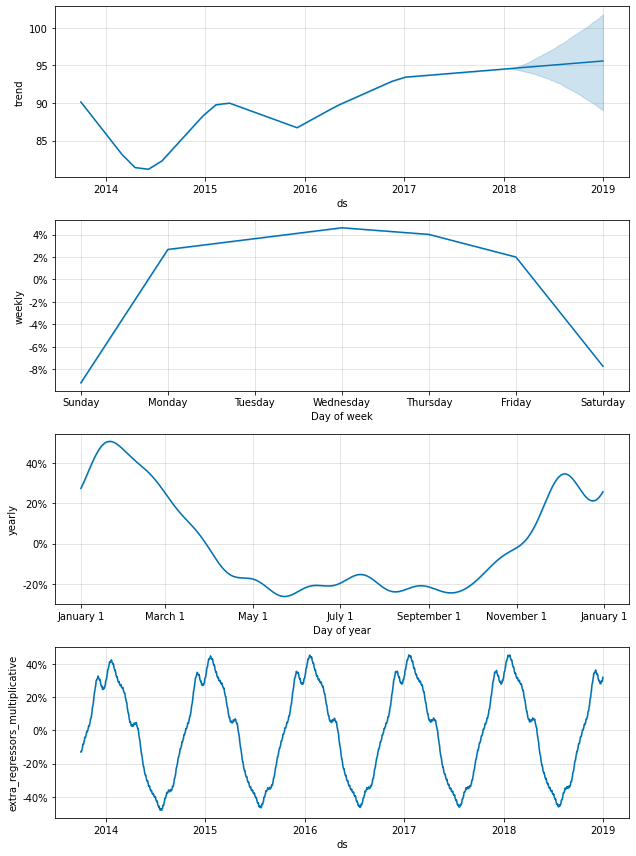

In [71]:

forecast = m.predict(future_regr)
fig = m.plot_components(forecast)

Adding the regressor of the predicted temperature wasn't helpful (note additive was 16.7)

16.307247324233945


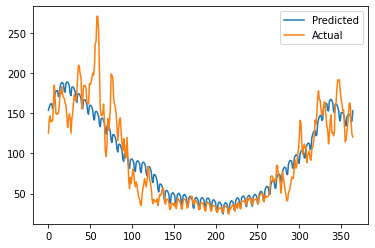

In [72]:
mae_and_plot(forecast,actual_2018)